# K-means Clustering

In [1]:
# import the library
%matplotlib inline

import pandas as pd
import numpy as np
import collections
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics.pairwise import euclidean_distances

# convert scientific notation to decimals
pd.set_option('display.float_format', lambda x: '%.2f' % x)
sns.set_style('whitegrid')

# Problem definition
Clustering flights by delay reasons and average delay.

____________
# Load the Data

### Cleaned, Merged dataset can be downloaded from here: https://www.kaggle.com/arwasheraky/cleaned-flight-delays-2015

In [2]:
df_flights = pd.read_csv('../data/flightsmerged.csv', low_memory=False)
print(df_flights.columns)
df_flights.head()

Index(['MONTH', 'FLIGHT_NUMBER', 'TAIL_NUMBER', 'SCHEDULED_DEPARTURE',
       'DEPARTURE_TIME', 'DEPARTURE_DELAY', 'SCHEDULED_TIME', 'DISTANCE',
       'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME', 'ARRIVAL_DELAY', 'DIVERTED',
       'CANCELLED', 'CANCELLATION_REASON', 'AIR_SYSTEM_DELAY',
       'SECURITY_DELAY', 'AIRLINE_DELAY', 'LATE_AIRCRAFT_DELAY',
       'WEATHER_DELAY', 'DATE', 'CLASS', 'AIRLINE_CODE', 'AIRLINE_NAME',
       'ORIGIN_AC', 'ORIGIN_NAME', 'ORIGIN_STATE', 'ORIGIN_LATITUDE',
       'ORIGIN_LONGITUDE', 'DESTINATION_AC', 'DESTINATION_NAME', 'DEST_STATE',
       'DEST_LATITUDE', 'DEST_LONGITUDE'],
      dtype='object')


,MONTH,FLIGHT_NUMBER,TAIL_NUMBER,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,SCHEDULED_TIME,DISTANCE,SCHEDULED_ARRIVAL,ARRIVAL_TIME,...,ORIGIN_AC,ORIGIN_NAME,ORIGIN_STATE,ORIGIN_LATITUDE,ORIGIN_LONGITUDE,DESTINATION_AC,DESTINATION_NAME,DEST_STATE,DEST_LATITUDE,DEST_LONGITUDE
0,1,98,N407AS,00:05:00,23:54:00,-11.00,205.00,1448,04:30:00,04:08:00,...,ANC,Ted Stevens Anchorage International Airport,AK,61.17,-150.00,SEA,Seattle-Tacoma International Airport,WA,47.45,-122.31
1,1,2336,N3KUAA,00:10:00,00:02:00,-8.00,280.00,2330,07:50:00,07:41:00,...,LAX,Los Angeles International Airport,CA,33.94,-118.41,PBI,Palm Beach International Airport,FL,26.68,-80.10
2,1,840,N171US,00:20:00,00:18:00,-2.00,286.00,2296,08:06:00,08:11:00,...,SFO,San Francisco International Airport,CA,37.62,-122.37,CLT,Charlotte Douglas International Airport,NC,35.21,-80.94
3,1,258,N3HYAA,00:20:00,00:15:00,-5.00,285.00,2342,08:05:00,07:56:00,...,LAX,Los Angeles International Airport,CA,33.94,-118.41,MIA,Miami International Airport,FL,25.79,-80.29
4,1,135,N527AS,00:25:00,00:24:00,-1.00,235.00,1448,03:20:00,02:59:00,...,SEA,Seattle-Tacoma International Airport,WA,47.45,-122.31,ANC,Ted Stevens Anchorage International Airport,AK,61.17,-150.00


_________________
# Feature Engineering

In [12]:
# Keep just the delayed flights

df = df_flights[df_flights['CLASS'] == 'Delayed']
df = df.drop(columns = ['CANCELLATION_REASON','CANCELLED'])
print("Original dataset : ",df_flights.shape)
print("Now : ",df.shape)

Original dataset :  (5697506, 33)
Now :  (5596829, 31)


In [19]:
delay_reason = df[['AIR_SYSTEM_DELAY','SECURITY_DELAY', 'AIRLINE_DELAY', 'LATE_AIRCRAFT_DELAY','WEATHER_DELAY']]
delay_reason.mean()

AIR_SYSTEM_DELAY      1.93
SECURITY_DELAY        0.01
AIRLINE_DELAY         2.10
LATE_AIRCRAFT_DELAY   2.73
WEATHER_DELAY         0.26
dtype: float64

In [21]:
df = df.dropna()
df.shape

(5109022, 32)

## Add a column

In [13]:
# Average delay column

df['AVG_DELAY'] = 0
df['AVG_DELAY'] = (df['DEPARTURE_DELAY'] + df['ARRIVAL_DELAY']) / 2.0
df['AVG_DELAY'].head(10)


0   -16.50
1    -8.50
2     1.50
3    -7.00
4   -11.00
5     1.50
6   -11.50
7     2.00
8   -12.00
9    -6.00
Name: AVG_DELAY, dtype: float64

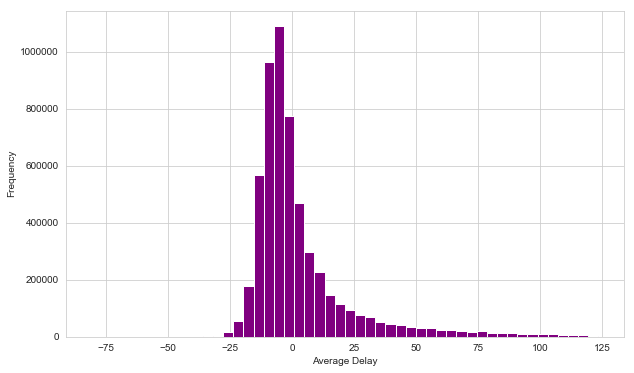

In [14]:
plt.figure(figsize=(10,6))
plt.hist(df['AVG_DELAY'], bins=50, color='purple')
plt.xlabel("Average Delay")
plt.ylabel("Frequency")
plt.show()

## Label Encodeing

In [61]:
# get_dummies

# Convert MONTH to STRING
df['MONTH'] = df['MONTH'].replace(to_replace = list(range(1, 13)),
                                  value=['1','2','3','4','5','6','7','8','9','10','11','12'])

categorical = ['MONTH']

df_dummies = pd.get_dummies(df[categorical])
df = pd.concat([df, df_dummies], axis=1)

## Select Model Columns

In [67]:
X_columns = ['AVG_DELAY'] + list(delay_reason.columns)

In [68]:
# normalize the columns
df_norm = df.copy()
df_norm = df_norm[X_columns]

for col in X_columns:
    df_norm[col] = df[col].astype(float)
    df_norm[col] = StandardScaler().fit_transform(df_norm[col].values.reshape(-1, 1))

df_norm.head()

,AVG_DELAY,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
0,-0.92,-0.23,-0.02,-0.22,-0.24,-0.07
1,-0.55,-0.23,-0.02,-0.22,-0.24,-0.07
2,-0.08,-0.23,-0.02,-0.22,-0.24,-0.07
3,-0.48,-0.23,-0.02,-0.22,-0.24,-0.07
4,-0.66,-0.23,-0.02,-0.22,-0.24,-0.07


_______
# Model Training

In [69]:
k = 5
kmeans = KMeans(n_clusters=k).fit(df_norm.values)

print(set(kmeans.labels_))
print(collections.Counter(kmeans.labels_))

{0, 1, 2, 3, 4}
Counter({0: 4625015, 4: 321159, 1: 142394, 2: 19319, 3: 1135})


In [70]:
df_results = df.copy()
df_norm['cluster'] = kmeans.labels_
df_results['cluster'] = kmeans.labels_
df_results = df_results.reset_index()

____________
# Analyze the Results

Cluster 0  : [(469, 3221), (326, 2817), (327, 2720)]
Cluster 1  : [(761, 119), (403, 115), (295, 107)]
Cluster 2  : [(55, 27), (407, 24), (1756, 22)]
Cluster 3  : [(161, 17), (61, 9), (223, 7)]
Cluster 4  : [(719, 359), (356, 314), (711, 311)]
AVG_DELAY


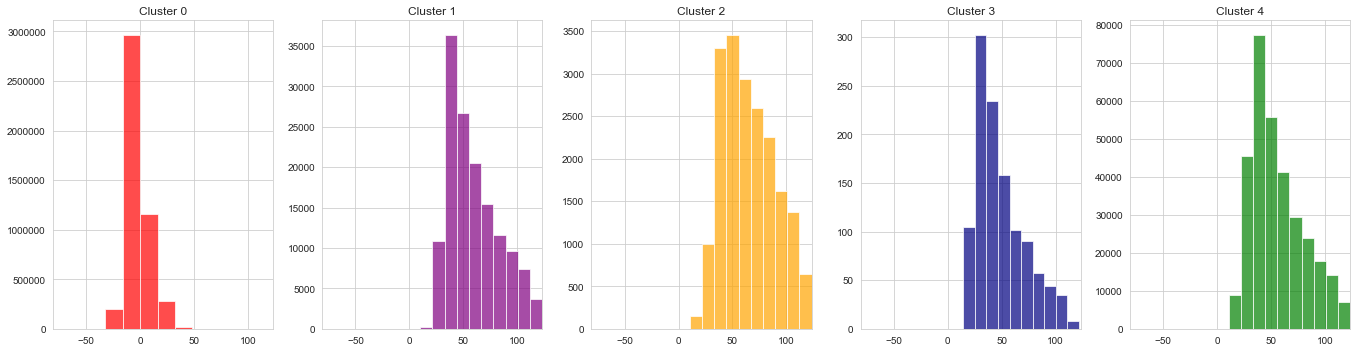

AIR_SYSTEM_DELAY


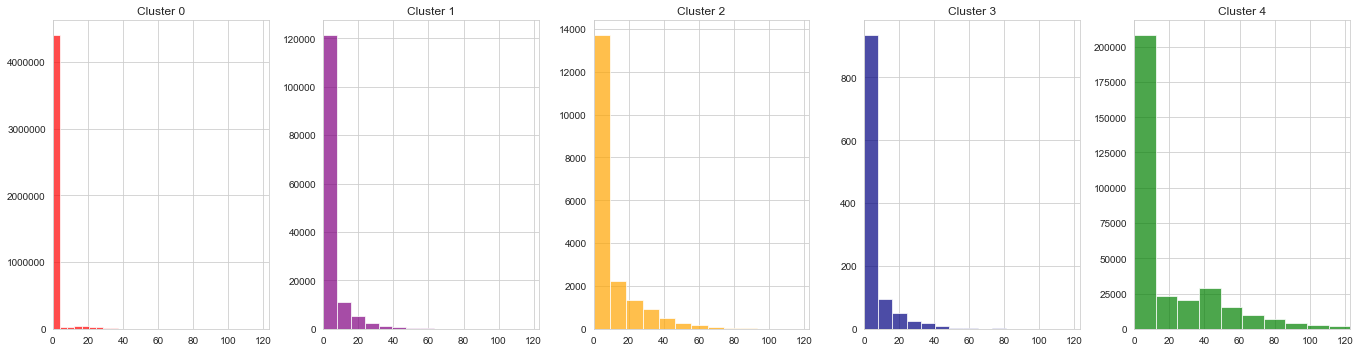

SECURITY_DELAY


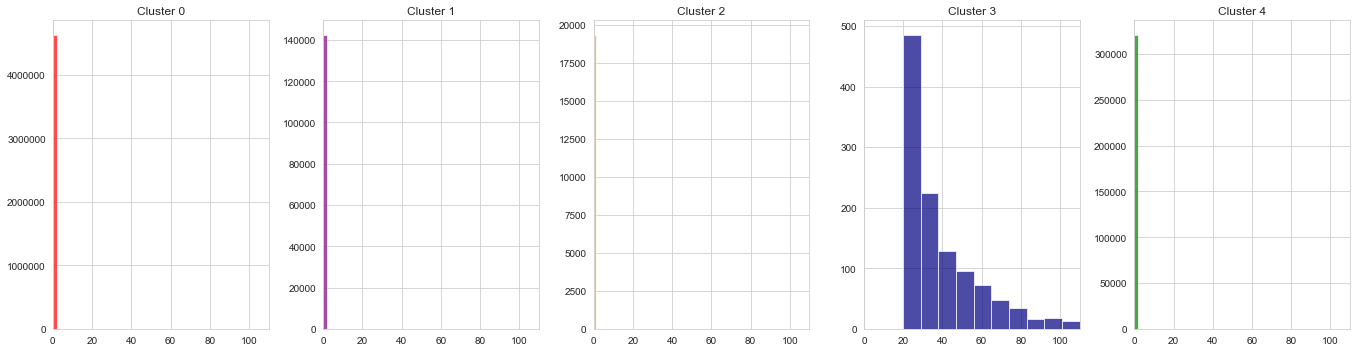

AIRLINE_DELAY


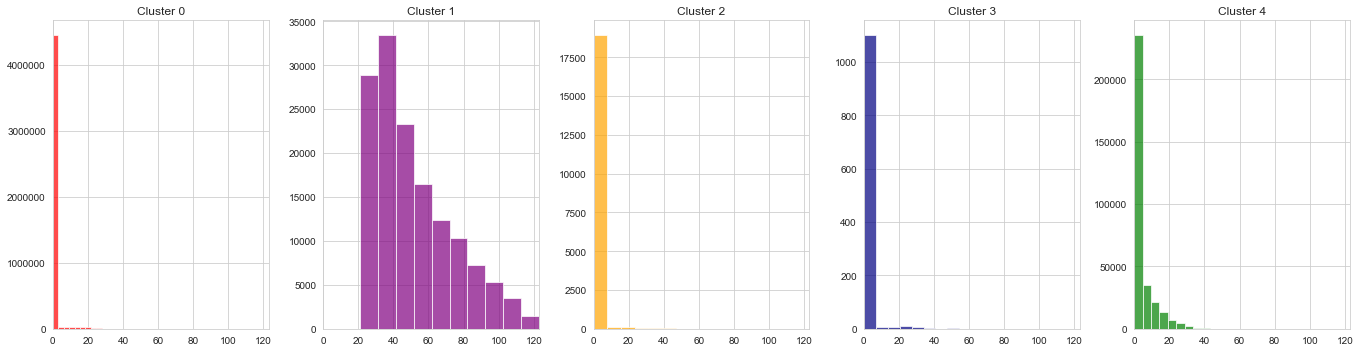

LATE_AIRCRAFT_DELAY


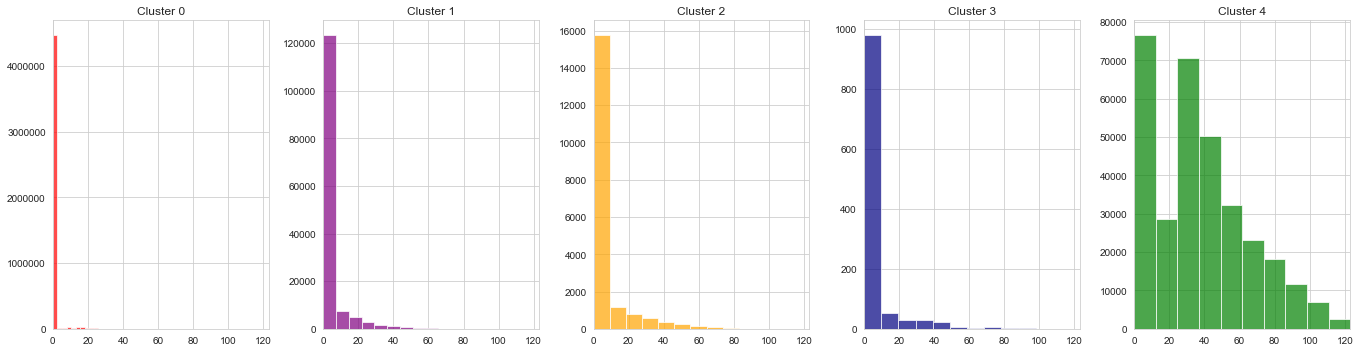

WEATHER_DELAY


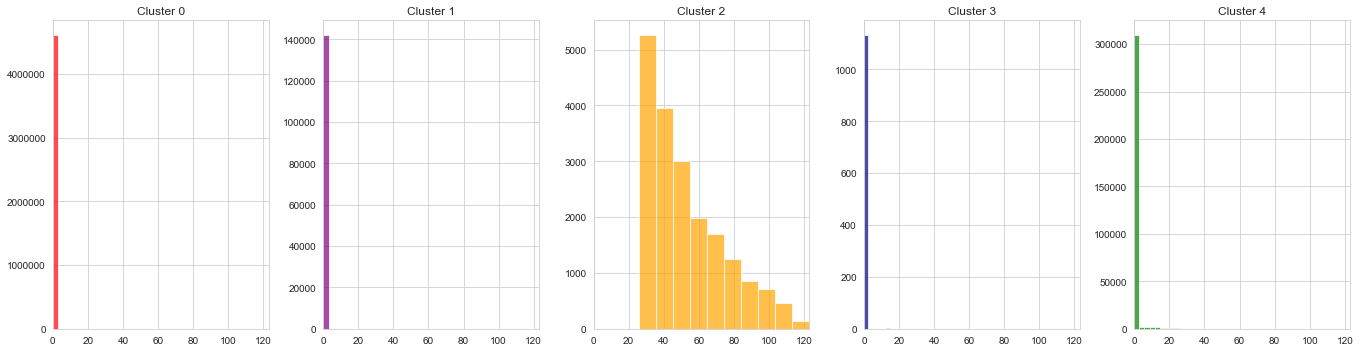

In [77]:

for cluster in sorted(set(kmeans.labels_)):
    print("Cluster",cluster," :",
          collections.Counter(df_results[df_results['cluster']==cluster]['FLIGHT_NUMBER']).most_common(3))

colors = ['red','purple','orange','navy','green']
n_clusters = len(set(kmeans.labels_))

for col in X_columns:
    print(col)
    i = 1
    plt.figure(figsize=(19,5))
    
    for cluster in sorted(set(kmeans.labels_)):
        plt.subplot(1, n_clusters, i)
        plt.xlim([df_results[col].min(),df_results[col].max()])
        plt.hist(df_results[df_results['cluster']==cluster][col], bins=10, label=str(cluster), alpha=0.7, color=colors[i-1])
        plt.title("Cluster "+str(cluster))
        i += 1
    
    plt.tight_layout()
    plt.show()
